## Jungfrau detector at ESRF

JUNGFRAU detectors can be made with different numbers of modules, each containing 512 × 1024 pixels. Each module contains 8 tiles. We take a JUNGFRAU-4M detector with 8 modules used at ESRF as an example here.

In [2]:
import os, shutil, sys
import h5py
import matplotlib.pyplot as plt
import numpy as np
from extra_geom import AGIPD_1MGeometry, JUNGFRAUGeometry

In [3]:
SimExBin = ':/gpfs/exfel/data/user/juncheng/miniconda3/envs/simex0.5/bin/'
os.environ["PATH"] += SimExBin

In [4]:
from SimEx.Calculators.CrystFELPhotonDiffractor import CrystFELPhotonDiffractor
from SimEx.Parameters.CrystFELPhotonDiffractorParameters import CrystFELPhotonDiffractorParameters
from SimEx.Parameters.PhotonBeamParameters import PhotonBeamParameters
from SimEx.Utilities.Units import electronvolt, joule, meter, radian

initializing ocelot...


In [5]:
def cleanPath(data_path):
    if os.path.isdir(data_path):
        shutil.rmtree(data_path)
    if os.path.isfile(data_path + '.h5'):
        os.remove(data_path + '.h5')

## Data path setup

In [6]:
data_path = './diffr'

In [7]:
cleanPath(data_path)

## X-ray beam parameters setup

In [8]:
photon_energy = 4972 # eV

In [9]:
beamParam = PhotonBeamParameters(
    photon_energy = photon_energy * electronvolt,  # photon energy in eV
    beam_diameter_fwhm=130e-9 * meter,      # focus diameter in m
    pulse_energy=45e-3 * joule,             # pulse energy in J
    photon_energy_relative_bandwidth=0.003, # relative bandwidth dE/E
    divergence=0.0 * radian,                # Beam divergence in rad
    photon_energy_spectrum_type='tophat',   # Spectrum type. Acceptable values are "tophat", "SASE", and "twocolor")
)

## Generate the JUNGFRAU geometry

In [3]:
# Positions are given in pixels
x_start, y_start = 1125-90, 1078
mod_width = (256 * 4) + (2 * 3)  # inc. 2px gaps between tiles
mod_height = (256 * 2) + 2

# The first 4 modules are rotated 180 degrees relative to the others.
# We pass the bottom, beam-right corner of the module regardless of its
# orientation, requiring a subtraction from the symmetric positions we'd
# otherwise calculate.
module_pos = [
    (x_start - mod_width, y_start - mod_height - (i * (mod_height + 33)))
    for i in range(4)
] + [
    (-x_start, -y_start + (i * (mod_height + 33))) for i in range(4)
]
orientations = [(-1, -1) for _ in range(4)] + [(1, 1) for _ in range(4)]

geom = JUNGFRAUGeometry.from_module_positions(module_pos, orientations=orientations)

 Expected data shape: (8, 512, 1024)


<AxesSubplot:title={'center':'Jungfrau detector geometry (No file)'}, xlabel='pixels', ylabel='pixels'>

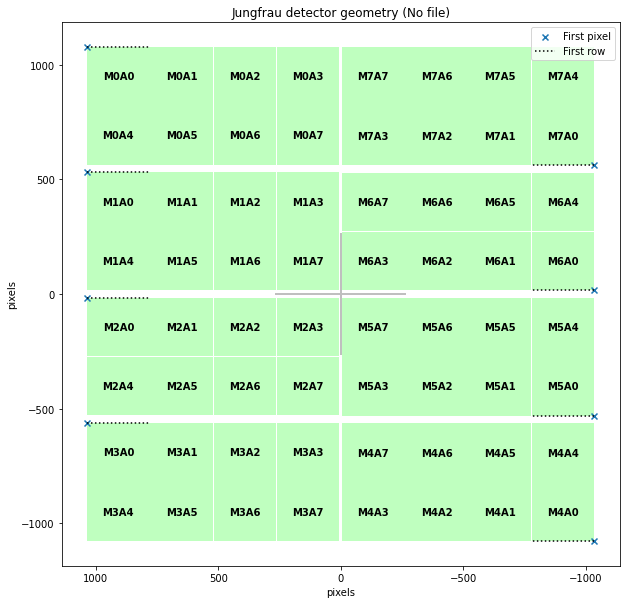

In [4]:
geom.inspect()

In [10]:
geom_file = 'Jungfrau.geom'

In [6]:
geom.write_crystfel_geom(geom_file,data_path='/data/data', dims=('frame', 'ss', 'fs'),
                         adu_per_ev=1, clen=0.101, photon_energy=photon_energy)   

## Diffraction calculator settings

We take lysozyme ([3WUL in PDB](https://www.rcsb.org/structure/3WUL)) as our sample.

In [11]:
diffParam = CrystFELPhotonDiffractorParameters(
    sample='3WUL.pdb',                    # Looks up pdb file in cwd, if not found, queries from RCSB pdb mirror.
    uniform_rotation=True,                # Apply random rotation
    number_of_diffraction_patterns=2,     #
    powder=False,                         # Set xto True to create a virtual powder diffraction pattern (unested)
    intensities_file=None,                # File that contains reflection intensities. If set to none, use uniform intensity distribution
    crystal_size_range=[1e-7, 1e-7],      # Range ([min,max]) in units of metres of crystal size.
    poissonize=False,                     # Set to True to add Poisson noise.
    number_of_background_photons=0,       # Change number to add uniformly distributed background photons.
    suppress_fringes=False,               # Set to True to suppress side maxima between reflection peaks.
    beam_parameters=beamParam,            # Beam parameters object from above
    detector_geometry=geom_file,          # External file that contains the detector geometry in CrystFEL notation.
)

In [12]:
diffractor = CrystFELPhotonDiffractor(
    parameters=diffParam, output_path=data_path
)

## Run the simulation

In [13]:
from timeit import default_timer as timer
start = timer()

status = diffractor.backengine()

end = timer()
print(end - start,'s') # Time in seconds
if (status == 0):
    print ("Successful!")
else:
    print ("Error code:",status)

128.13771269842982 s
Successful!


In [14]:
diffractor.saveH5()

Renaming diffr_out-1.h5 to diffr_out_0000001.h5.
Renaming diffr_out-2.h5 to diffr_out_0000002.h5.
Linking all patterns into /gpfs/exfel/data/user/juncheng/SimEx-notebooks/ESRF-SerialCrystallography/diffr.h5.


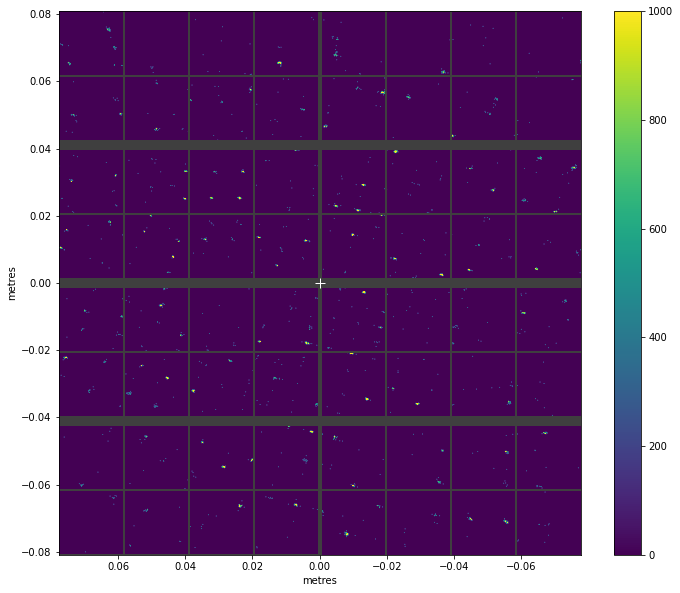

In [18]:
data_f = h5py.File(data_path + '.h5', 'r')
frame = data_f['data/0000001/data'][...].reshape(8,512,1024)

fig, ax = plt.subplots(figsize=(12, 10))
geom_read = JUNGFRAUGeometry.from_crystfel_geom(geom_file)
geom_read.plot_data_fast(frame, axis_units='m', ax=ax, vmax=1000);

This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No. 823852.